In [2]:
import sqlite3 as sql

import numpy as np
import pandas as pd
from pandas import cut, read_sql
import pickle as pkl
from random import choices
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from numpy import interp

from torch.nn.functional import one_hot
import torch
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

/groups/icecube/qgf305/anaconda3/envs/graphnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_roc_and_auc(pred, target, labels=None):
    if labels==None:
        fpr, tpr, _ = roc_curve(pred, target)
    else: 
        fpr, tpr, _ = roc_curve(pred, target, pos_label=labels)
    auc_score = auc(fpr,tpr)
    return fpr,tpr,auc_score 

def plot_roc(data, target):#, save_dir, save_as_csv = False):
    fpr, tpr, auc = get_roc_and_auc(data,  target)
    
    width = 3.176*2
    height = 2.388*2
    fig = plt.figure(figsize = (width,height))
    plt.plot(fpr,tpr, label ='%s'%(round(auc,3)))
    plt.legend()
    plt.title('feature selection: 10^6')
    plt.ylabel('True Positive Rate', fontsize = 12)
    plt.xlabel('False Positive Rate', fontsize = 12)
    return

In [4]:
pids = [1,12,13]

In [5]:
indir = "/groups/icecube/peter/storage/Multiclassification/Real/last_one_lvl3MC/dynedge_pid_Real_run_21.5_mill_equal_frac_/results_first.csv"
results = pd.read_csv(indir, index_col=[0]).sort_values('event_no').reset_index()

In [6]:
print(np.unique(results["pid"]))
results

[-16. -14. -12.  -1.  12.  13.  14.  16.]


,index,pid_noise_pred,pid_muon_pred,pid_neutrino_pred,pid,event_no
0,5120686,0.998500,0.000070,0.001430,-1.0,0.0
1,4242588,0.990103,0.001291,0.008606,-1.0,4.0
2,1771911,0.954151,0.002227,0.043622,-1.0,9.0
3,5521011,0.980069,0.000406,0.019525,-1.0,27.0
4,2840254,1.000000,0.000000,0.000000,-1.0,43.0
...,...,...,...,...,...,...
7424995,5850206,1.000000,0.000000,0.000000,-1.0,98614183.0
7424996,1702896,1.000000,0.000000,0.000000,-1.0,98614190.0
7424997,2438854,1.000000,0.000000,0.000000,-1.0,98614194.0
7424998,2283818,0.999685,0.000012,0.000303,-1.0,98614197.0


In [7]:
## transform data
# remove anti
results['pid'] = results['pid'].apply(abs)
# make all neutrinos the same class; to match prediction
results.loc[results['pid']==14, "pid"]=12
results.loc[results['pid']==16, "pid"]=12
results["pid"] = results["pid"].astype("int")
np.unique(results["pid"])

array([ 1, 12, 13])

In [8]:
# Binarize the output
pid_true = label_binarize(results["pid"], classes=[1, 12, 13])
nb_classes = pid_true.shape[1]

In [13]:
y_test = pid_true 
y_prob = results[["pid_noise_pred","pid_muon_pred","pid_neutrino_pred"]]
y_test
np.unique(y_test[2])

array([0, 1])

In [10]:
y_prob

,pid_noise_pred,pid_muon_pred,pid_neutrino_pred
0,0.998500,0.000070,0.001430
1,0.990103,0.001291,0.008606
2,0.954151,0.002227,0.043622
3,0.980069,0.000406,0.019525
4,1.000000,0.000000,0.000000
...,...,...,...
7424995,1.000000,0.000000,0.000000
7424996,1.000000,0.000000,0.000000
7424997,1.000000,0.000000,0.000000
7424998,0.999685,0.000012,0.000303


In [56]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob.iloc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.values.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

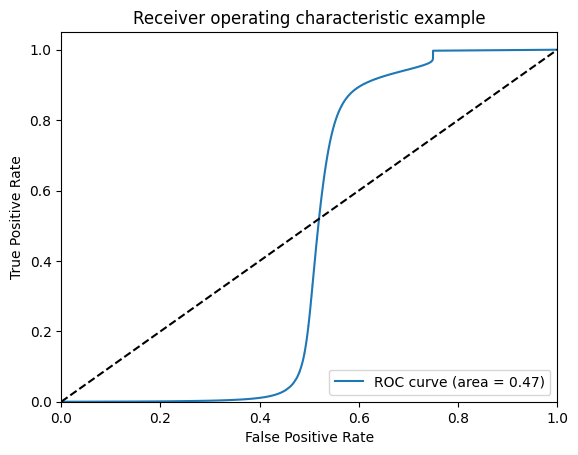

In [69]:
# Plot of a ROC curve for a specific class
test = 1
plt.figure()
plt.plot(fpr[test], tpr[test], label='ROC curve (area = %0.2f)' % roc_auc[test])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [58]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(nb_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= nb_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/tmp/ipykernel_36023/2474506920.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


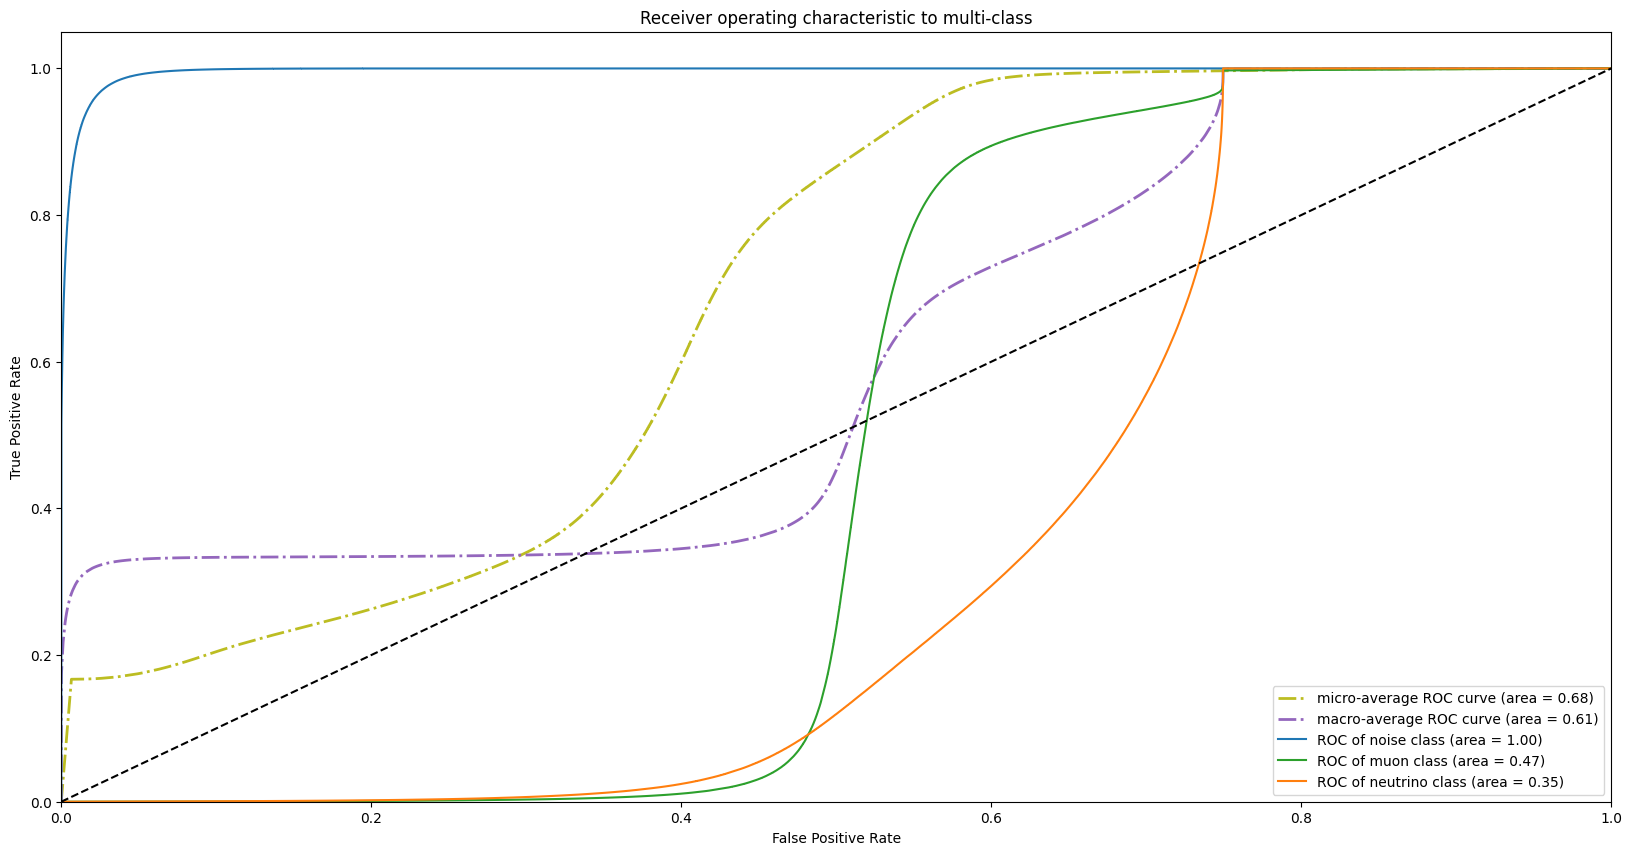

In [77]:
# Plot all ROC curves
plt.figure(figsize=(20,10))
plt.plot(
      fpr["micro"], tpr["micro"],
      color="tab:olive", linestyle='dashdot',
      label='micro-average ROC curve (area = {0:0.2f})'
            ''.format(roc_auc["micro"]),
      linewidth=2)

plt.plot(
      fpr["macro"], tpr["macro"],
      color="tab:purple", linestyle='dashdot',
      label='macro-average ROC curve (area = {0:0.2f})'
            ''.format(roc_auc["macro"]),
      linewidth=2)

colors=["tab:blue","tab:green","tab:orange"]

for i, item in enumerate(["noise", "muon", "neutrino"]):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='ROC of {0} class (area = {1:0.2f})'
                                   ''.format(item, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [65]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.605663 (macro),
0.605656 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.605663 (macro),
0.605656 (weighted by prevalence)
